In [1]:
import os
import torch
import joblib
import matplotlib


from mpp.utils.data_processing import DataProcessor
from mpp.utils.model_utils import train_and_evaluate_models
from mpp.models.neural_network import NeuralNetworkModel
from mpp.models.random_forest import RandomForestModel
from mpp.models.gradient_boosting import GradientBoostingModel
from mpp.models.knn import BaselineKNN
from mpp.utils.visualization import plot_correlation_matrix, plot_results, plot_training_process, plot_multiple_training_processes, plot_feature_correlations
from mpp.tuning.tune import HyperparameterTuning

import warnings
warnings.filterwarnings('ignore')

# make figures appear inline
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
def model_exists(model_path):
    return os.path.exists(model_path)

In [4]:
# Load the data
processor = DataProcessor("data/data.csv")
data = processor.load_data()
data_with_features = processor.extract_features()
print(data_with_features)

       pIC50  num_atoms     logP    MolWt  NumAtoms  NumBonds  NumC  NumO  \
0       4.26         25  4.15910  367.455        25        28     0     2   
1       4.34         36  3.67430  506.434        36        40     2     4   
2       4.53         23  1.53610  317.389        23        25    10     3   
3       4.56         22  0.95100  301.394        22        24     9     1   
4       4.59         21  3.21300  294.383        21        23     2     0   
...      ...        ...      ...      ...       ...       ...   ...   ...   
15032   0.00         24  3.21560  333.420        24        26     2     0   
15033   0.00         19  5.45270  275.461        19        19    11     0   
15034   0.00         17  4.67250  247.407        17        17     9     0   
15035   0.00         22  3.93289  306.394        22        25     1     0   
15036   0.02         13  1.70887  181.131        13        13     2     2   

       NumN  NumCl  NumF  NumBr  NumI  
0         1      0     0      0    

In [5]:
# Split the data
X_train, X_test, y_train_pic50, y_test_pic50, y_train_logP, y_test_logP = processor.split_data()

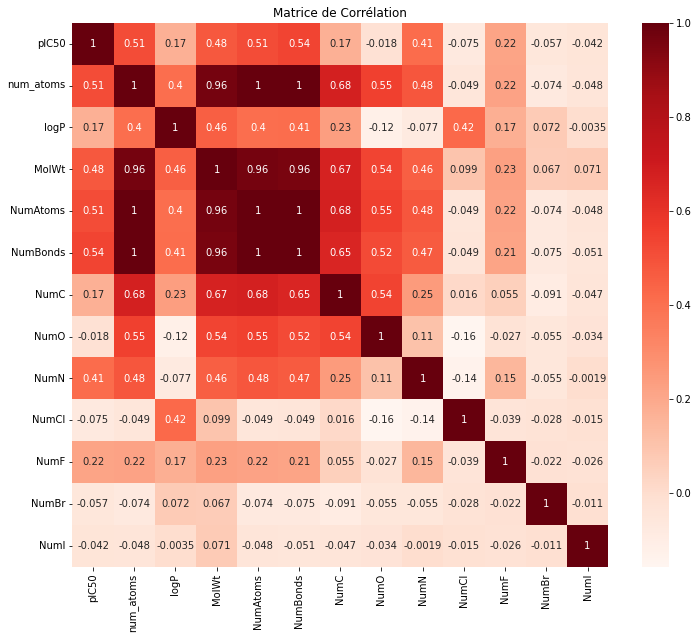

In [6]:
# Feature visualization
plot_correlation_matrix(data_with_features)

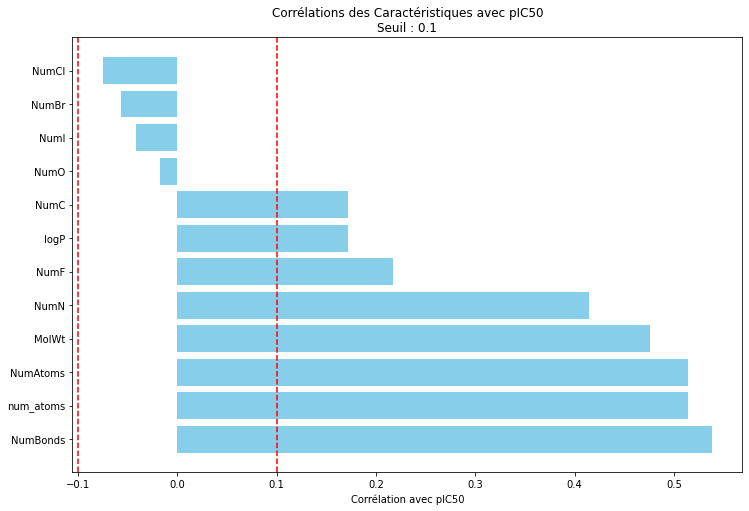

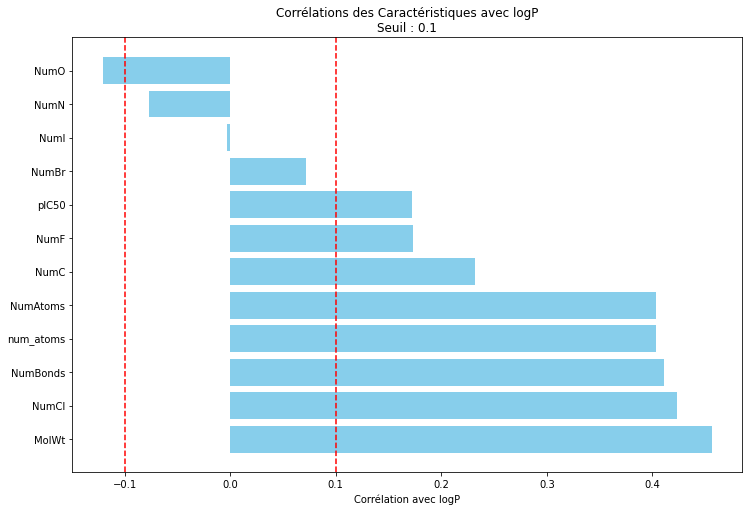

In [7]:
# Plot feature correlations with pIC50 and logP
plot_feature_correlations(data_with_features, 'pIC50', output_path="feature_correlations_pic50.png")
plot_feature_correlations(data_with_features, 'logP', output_path="feature_correlations_logP.png")

Loaded existing pIC50 params.
Best trial : {'lr': 0.00032072030466630806, 'epochs': 88, 'batch_size': 108, 'hidden_layers': 3, 'hidden_size_0': 151, 'hidden_size_1': 222, 'hidden_size_2': 205, 'patience': 9}



Neural Network Model MSE for pIC50: 0.9687908027629027


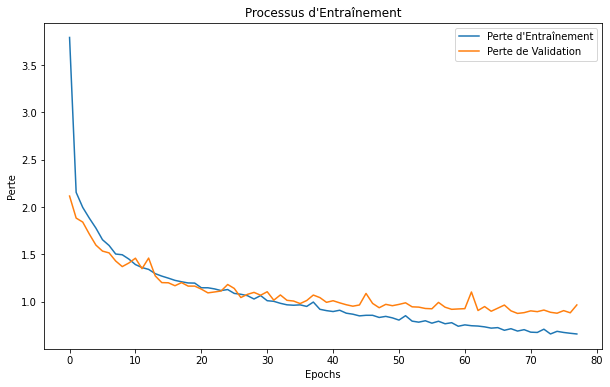

In [10]:
# Hyperparameter tuning for Neural Network (pIC50)
if model_exists('params/nn_best_params_pic50.pkl'):
    print("Loaded existing pIC50 params.\n")
    loaded_best_params_pic50 = joblib.load('params/nn_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50}")
    nn_model_pic50 = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[loaded_best_params_pic50[f"hidden_size_{i}"] for i in range(loaded_best_params_pic50["hidden_layers"])],
        lr=loaded_best_params_pic50["lr"],
        epochs=loaded_best_params_pic50["epochs"],
        batch_size=loaded_best_params_pic50["batch_size"],
        patience=loaded_best_params_pic50["patience"]
    )
    training_loss_pic50, validation_loss_pic50 = nn_model_pic50.train(X_train, y_train_pic50, X_test, y_test_pic50)
    print(f"Neural Network Model MSE for pIC50: {nn_model_pic50.evaluate(X_test, y_test_pic50)}")
    plot_training_process(training_loss_pic50, validation_loss_pic50, output_path="training_process_pic50.png")
else:
    tuner_pic50 = HyperparameterTuning(X_train, y_train_pic50, "Neural Network")
    best_params_pic50 = tuner_pic50.tune(n_trials=50)
    joblib.dump(best_params_pic50, 'params/nn_best_params_pic50.pkl')
    nn_model_pic50 = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_pic50[f"hidden_size_{i}"] for i in range(best_params_pic50["hidden_layers"])],
        lr=best_params_pic50["lr"],
        epochs=best_params_pic50["epochs"],
        batch_size=best_params_pic50["batch_size"],
        patience=best_params_pic50["patience"]
    )
    training_loss_pic50, validation_loss_pic50 = nn_model_pic50.train(X_train, y_train_pic50, X_test, y_test_pic50)
    print(f"Neural Network Model MSE for pIC50: {nn_model_pic50.evaluate(X_test, y_test_pic50)}")
    plot_training_process(training_loss_pic50, validation_loss_pic50, output_path="training_process_pic50.png")


In [19]:
# Hyperparameter tuning for Neural Network (logP)
if model_exists('params/nn_best_params_logP.pkl'):
    print("Loaded existing logP params.\n")
    loaded_best_params_logP = joblib.load('params/nn_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP}")
    nn_model_logP = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[loaded_best_params_logP[f"hidden_size_{i}"] for i in range(loaded_best_params_logP["hidden_layers"])],
        lr=loaded_best_params_logP["lr"],
        epochs=loaded_best_params_logP["epochs"],
        batch_size=loaded_best_params_logP["batch_size"],
        patience=loaded_best_params_logP["patience"]
    )
    training_loss_logP, validation_loss_logP = nn_model_logP.train(X_train, y_train_logP, X_test, y_test_logP)
    print(f"Neural Network Model MSE for logP: {nn_model_logP.evaluate(X_test, y_test_logP)}")
    plot_training_process(training_loss_logP, validation_loss_logP, output_path="training_process_logP.png")
else:
    tuner_logP = HyperparameterTuning(X_train, y_train_logP, "Neural Network")
    best_params_logP = tuner_logP.tune(n_trials=50)
    joblib.dump(best_params_logP, 'params/nn_best_params_logP.pkl')
    nn_model_logP = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_logP[f"hidden_size_{i}"] for i in range(best_params_logP["hidden_layers"])],
        lr=best_params_logP["lr"],
        epochs=best_params_logP["epochs"],
        batch_size=best_params_logP["batch_size"],
        patience=best_params_logP["patience"]
    )
    training_loss_logP, validation_loss_logP = nn_model_logP.train(X_train, y_train_logP, X_test, y_test_logP)
    torch.save(nn_model_logP.model.state_dict(), 'models/nn_model_logP.pth')
    print(f"Neural Network Model MSE for logP: {nn_model_logP.evaluate(X_test, y_test_logP)}")
    plot_training_process(training_loss_logP, validation_loss_logP, output_path="training_process_logP.png")


RuntimeError: Error(s) in loading state_dict for NeuralNetwork:
	Unexpected key(s) in state_dict: "network.6.weight", "network.6.bias". 
	size mismatch for network.0.weight: copying a param with shape torch.Size([130, 11]) from checkpoint, the shape in current model is torch.Size([64, 11]).
	size mismatch for network.0.bias: copying a param with shape torch.Size([130]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for network.2.weight: copying a param with shape torch.Size([146, 130]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for network.2.bias: copying a param with shape torch.Size([146]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for network.4.weight: copying a param with shape torch.Size([160, 146]) from checkpoint, the shape in current model is torch.Size([1, 32]).
	size mismatch for network.4.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([1]).

In [12]:
# Hyperparameter tuning and model training for KNN (pIC50)
if model_exists('params/knn_best_params_pic50.pkl'):
    print("Loaded existing pIC50 KNN params.\n")
    loaded_best_params_pic50_knn = joblib.load('params/knn_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50_knn}")
    knn_model_pic50 = BaselineKNN(n_neighbors=loaded_best_params_pic50_knn["n_neighbors"])
    knn_model_pic50.train(X_train, y_train_pic50)
    print(f"KNN Model MSE for pIC50: {knn_model_pic50.evaluate(X_test, y_test_pic50)}")
else:
    tuner_pic50_knn = HyperparameterTuning(X_train, y_train_pic50, "KNN")
    best_params_pic50_knn = tuner_pic50_knn.tune(n_trials=50)
    joblib.dump(best_params_pic50_knn, 'params/knn_best_params_pic50.pkl')
    knn_model_pic50 = BaselineKNN(n_neighbors=best_params_pic50_knn["n_neighbors"])
    knn_model_pic50.train(X_train, y_train_pic50)
    print(f"KNN Model MSE for pIC50: {knn_model_pic50.evaluate(X_test, y_test_pic50)}")


Loaded existing pIC50 KNN params.

Best trial : {'n_neighbors': 3}
KNN Model MSE for pIC50: 1.7327211768617021


In [17]:
# Hyperparameter tuning and model training for KNN (logP)
if model_exists('params/knn_best_params_logP.pkl'):
    print("Loaded existing logP KNN params.\n")
    loaded_best_params_logP_knn = joblib.load('params/knn_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP_knn}")
    knn_model_logP = BaselineKNN(n_neighbors=loaded_best_params_logP_knn["n_neighbors"])
    knn_model_logP.train(X_train, y_train_logP)
    print(f"KNN Model MSE for logP: {knn_model_logP.evaluate(X_test, y_test_logP)}")
else:
    tuner_logP_knn = HyperparameterTuning(X_train, y_train_logP, "KNN")
    best_params_logP_knn = tuner_logP_knn.tune(n_trials=50)
    joblib.dump(best_params_logP_knn, 'params/knn_best_params_logP.pkl')
    knn_model_logP = BaselineKNN(n_neighbors=best_params_logP_knn["n_neighbors"])
    knn_model_logP.train(X_train, y_train_logP)
    print(f"KNN Model MSE for logP: {knn_model_logP.evaluate(X_test, y_test_logP)}")

Loaded existing logP KNN params.

Best trial : {'n_neighbors': 4}
KNN Model MSE for logP: 0.7276687296320423


In [19]:
# Hyperparameter tuning and model training for Random Forest (pIC50)
if model_exists('params/rf_best_params_pic50.pkl'):
    print("Loaded existing pIC50 Random Forest params.\n")
    loaded_best_params_pic50_rf = joblib.load('params/rf_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50_rf}")
    rf_model_pic50 = RandomForestModel(n_estimators=loaded_best_params_pic50_rf["n_estimators"], 
                                       max_depth=loaded_best_params_pic50_rf["max_depth"])
    rf_model_pic50.train(X_train, y_train_pic50)
    print(f"Random Forest Model MSE for pIC50: {rf_model_pic50.evaluate(X_test, y_test_pic50)}")
else:
    tuner_pic50_rf = HyperparameterTuning(X_train, y_train_pic50, "Random Forest")
    best_params_pic50_rf = tuner_pic50_rf.tune(n_trials=50)
    joblib.dump(best_params_pic50_rf, 'params/rf_best_params_pic50.pkl')
    rf_model_pic50 = RandomForestModel(n_estimators=best_params_pic50_rf["n_estimators"], 
                                       max_depth=best_params_pic50_rf["max_depth"])
    rf_model_pic50.train(X_train, y_train_pic50)
    print(f"Random Forest Model MSE for pIC50: {rf_model_pic50.evaluate(X_test, y_test_pic50)}")


Loaded existing pIC50 Random Forest params.

Best trial : {'n_estimators': 165, 'max_depth': 28}
Random Forest Model MSE for pIC50: 0.9722490770946856


In [18]:
# Hyperparameter tuning and model training for Random Forest (logP)
if model_exists('params/rf_best_params_logP.pkl'):
    print("Loaded existing logP Random Forest params.\n")
    loaded_best_params_logP_rf = joblib.load('params/rf_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP_rf}")
    rf_model_logP = RandomForestModel(n_estimators=loaded_best_params_logP_rf["n_estimators"], max_depth=loaded_best_params_logP_rf["max_depth"])
    rf_model_logP.train(X_train, y_train_logP)
    print(f"Random Forest Model MSE for logP: {rf_model_logP.evaluate(X_test, y_test_logP)}")
else:
    tuner_logP_rf = HyperparameterTuning(X_train, y_train_logP, "Random Forest")
    best_params_logP_rf = tuner_logP_rf.tune(n_trials=50)
    joblib.dump(best_params_logP_rf, 'params/rf_best_params_logP.pkl')
    rf_model_logP = RandomForestModel(n_estimators=best_params_logP_rf["n_estimators"], max_depth=best_params_logP_rf["max_depth"])
    rf_model_logP.train(X_train, y_train_logP)
    print(f"Random Forest Model MSE for logP: {rf_model_logP.evaluate(X_test, y_test_logP)}")


[I 2024-06-17 17:15:59,603] A new study created in memory with name: no-name-01bbf60e-bca0-4d1b-9de9-0a965000f728


[W 2024-06-17 17:16:19,841] Trial 0 failed with parameters: {'n_estimators': 143, 'max_depth': 24} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\dav-9\miniconda3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\dav-9\OneDrive\Bureau\David\UNIGE\Data mining\mpp\mpp\tuning\tune.py", line 82, in objective
    score = cross_val_score(model.model, X_train, y_train, cv=3, scoring="neg_mean_squared_error")
  File "C:\Users\dav-9\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 562, in cross_val_score
    cv_results = cross_validate(
  File "C:\Users\dav-9\miniconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\dav-9\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 309, in cross_validate
    results = parallel(
  File "C:\Users\dav-9\

KeyboardInterrupt: 

In [26]:
# Hyperparameter tuning and model training for Gradient Boosting (pIC50)
if model_exists('params/gb_best_params_pic50.pkl'):
    print("Loaded existing pIC50 Gradient Boosting params.\n")
    loaded_best_params_pic50_gb = joblib.load('params/gb_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50_gb}")
    gb_model_pic50 = GradientBoostingModel(n_estimators=loaded_best_params_pic50_gb["n_estimators"], 
                                           learning_rate=loaded_best_params_pic50_gb["learning_rate"], 
                                           max_depth=loaded_best_params_pic50_gb["max_depth"])
    gb_model_pic50.train(X_train, y_train_pic50)
    print(f"Gradient Boosting Model MSE for pIC50: {gb_model_pic50.evaluate(X_test, y_test_pic50)}")
else:
    tuner_pic50_gb = HyperparameterTuning(X_train, y_train_pic50, "Gradient Boosting")
    best_params_pic50_gb = tuner_pic50_gb.tune(n_trials=50)
    joblib.dump(best_params_pic50_gb, 'params/gb_best_params_pic50.pkl')
    gb_model_pic50 = GradientBoostingModel(n_estimators=best_params_pic50_gb["n_estimators"], 
                                           learning_rate=best_params_pic50_gb["learning_rate"], 
                                           max_depth=best_params_pic50_gb["max_depth"])
    gb_model_pic50.train(X_train, y_train_pic50)
    print(f"Gradient Boosting Model MSE for pIC50: {gb_model_pic50.evaluate(X_test, y_test_pic50)}")


[I 2024-06-05 17:46:31,067] A new study created in memory with name: no-name-c0401a11-51c2-4729-991e-bf1dd22c9893


Hyperparameter Tuning (Gradient Boosting):   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-05 17:46:41,844] Trial 0 finished with value: 1.9741623309396343 and parameters: {'n_estimators': 170, 'learning_rate': 0.015455488347100876, 'max_depth': 17}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:46:54,672] Trial 1 finished with value: 2.1601913554817034 and parameters: {'n_estimators': 190, 'learning_rate': 0.03570346591583864, 'max_depth': 22}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:47:03,749] Trial 2 finished with value: 4.294957272258382 and parameters: {'n_estimators': 136, 'learning_rate': 0.0017518093655901003, 'max_depth': 24}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:47:12,409] Trial 3 finished with value: 2.143069195163415 and parameters: {'n_estimators': 127, 'learning_rate': 0.03441006957915809, 'max_depth': 31}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:47:23,856] Trial 4 finished with value: 4.4924478324350705 and parameters: {'n_estimators': 166, 'learning_rat

Best trial for Gradient Boosting: {'n_estimators': 172, 'learning_rate': 0.05435332478136519, 'max_depth': 7}
Gradient Boosting Model MSE for pIC50: 1.0590004873622547


In [12]:
# Hyperparameter tuning and model training for Gradient Boosting (logP)
if model_exists('params/gb_best_params_logP.pkl'):
    print("Loaded existing logP Gradient Boosting params.\n")
    loaded_best_params_logP_gb = joblib.load('params/gb_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP_gb}")
    gb_model_logP = GradientBoostingModel(n_estimators=loaded_best_params_logP_gb["n_estimators"], 
                                          learning_rate=loaded_best_params_logP_gb["learning_rate"], 
                                          max_depth=loaded_best_params_logP_gb["max_depth"])
    gb_model_logP.train(X_train, y_train_logP)
    print(f"Gradient Boosting Model MSE for logP: {gb_model_logP.evaluate(X_test, y_test_logP)}")
else:
    tuner_logP_gb = HyperparameterTuning(X_train, y_train_logP, "Gradient Boosting")
    best_params_logP_gb = tuner_logP_gb.tune(n_trials=50)
    joblib.dump(best_params_logP_gb, 'params/gb_best_params_logP.pkl')
    gb_model_logP = GradientBoostingModel(n_estimators=best_params_logP_gb["n_estimators"], 
                                          learning_rate=best_params_logP_gb["learning_rate"], 
                                          max_depth=best_params_logP_gb["max_depth"])
    gb_model_logP.train(X_train, y_train_logP)
    print(f"Gradient Boosting Model MSE for logP: {gb_model_logP.evaluate(X_test, y_test_logP)}")


ModuleNotFoundError: No module named '_loss'

In [28]:
# Results visualization for pIC50
results_pic50 = {
    "Neural Network": nn_model_pic50.evaluate(X_test, y_test_pic50),
    "KNN": knn_model_pic50.evaluate(X_test, y_test_pic50),
    "Random Forest": rf_model_pic50.evaluate(X_test, y_test_pic50),
    "Gradient Boosting": gb_model_pic50.evaluate(X_test, y_test_pic50)
}

In [29]:
# Results visualization for logP
results_logP = {
    "Neural Network": nn_model_logP.evaluate(X_test, y_test_logP),
    "KNN": knn_model_logP.evaluate(X_test, y_test_logP),
    "Random Forest": rf_model_logP.evaluate(X_test, y_test_logP),
    "Gradient Boosting": gb_model_logP.evaluate(X_test, y_test_logP)
}

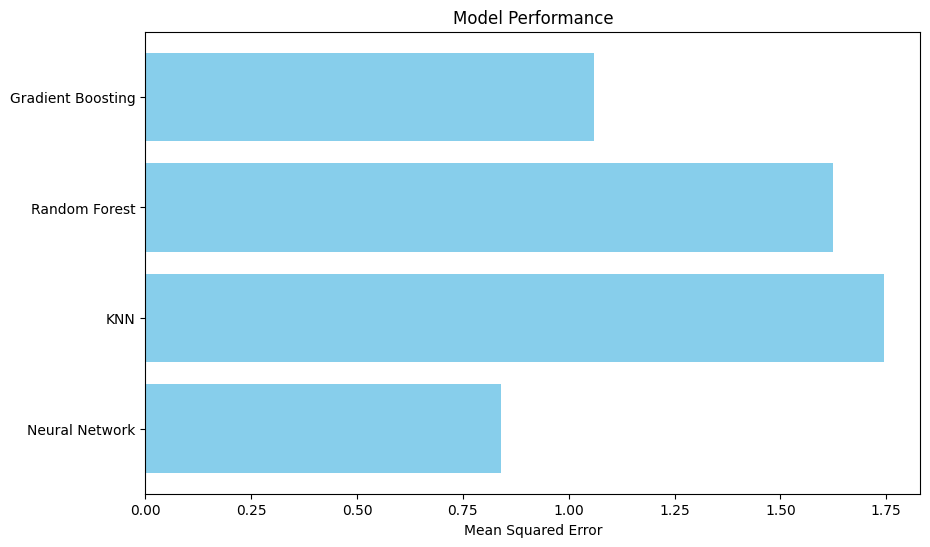

In [30]:
# Results visualization for pIC50
plot_results(results_pic50)

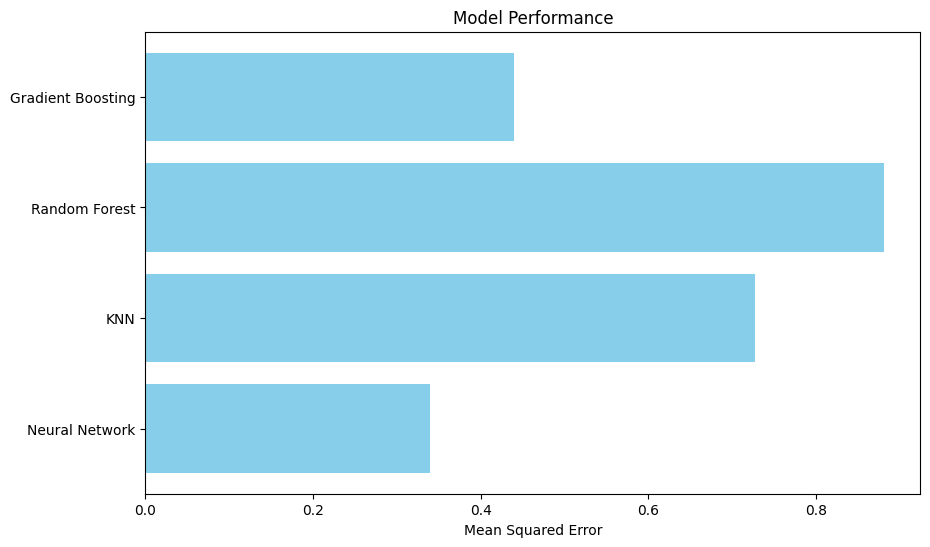

In [31]:
# Results visualization for logP
plot_results(results_logP)

In [33]:
# Visualize training processes for all models (pIC50)
# plot_multiple_training_processes(training_losses_pic50, validation_losses_pic50)


In [34]:
# Visualize training processes for all models (logP)
# plot_multiple_training_processes(training_losses_logP, validation_losses_logP)
